# Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import random as rd
import os
from IPython.display import clear_output
from tqdm import tqdm

2022-05-13 10:40:42.574495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 10:40:42.574523: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class bcolors:
    green = '\033[34m' 
    yellow = '\033[33m' 
    red = '\033[31m' 
    blue = '\033[36m'
    reset = '\033[0m' #RESET COLOR

# Intervalle parametres

In [3]:
#GeV [min,max]

M1_range = M2_range = M3_range = [50, 5000]
mA_range = [50, 5000]
tanB_range = [2, 60]
mu_range = [-10**4, 10**4]
At_range = Ab_range = Atau_range = [-10**4, 10**4]
Mq1L_range = Mq3L_range = [50, 5000]
MuR_range = MdR_range = MtR_range = MbR_range = [50, 5000]
MeL_range = MtauL_range = MeR_range = MtauR_range = [50, 5000]

PMSSM_range= [M1_range, M2_range, M3_range, mA_range, tanB_range, mu_range, At_range, Ab_range, 
              Atau_range, Mq1L_range, Mq3L_range, MuR_range, MdR_range, MtR_range, MbR_range,
             MeL_range, MtauL_range, MeR_range, MtauR_range]


def PMSSM_param_random(PMSSM_range):
    PMSSM_sample_random = []
    
    for i in PMSSM_range:
        random_value = rd.uniform(i[0],i[1])
        normalized_value = (random_value - i[0]) / (i[1] -i[0] )
        PMSSM_sample_random.append(normalized_value)
    
    return PMSSM_sample_random

# Dataset

In [4]:
#Batch de len=128 avec 19 parametres donc matrice 19*126
taille_dataset = 1000
dataset = []
taille_batch = 10

for i in range(taille_dataset):
    batch = [0 for k in range(taille_batch)]
    for j in range(len(batch)):
        batch[j] = PMSSM_param_random(PMSSM_range)
    batch = tf.convert_to_tensor(batch)
    
    dataset.append(batch)

2022-05-13 10:40:45.369985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-13 10:40:45.370014: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-13 10:40:45.370036: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MPC): /proc/driver/nvidia/version does not exist
2022-05-13 10:40:45.370322: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Fichier slha 

In [5]:
def write_slha(PMSSM_NN, nom_slha):
    f = open(nom_slha, "w")
    
    f.write("BLOCK MODSEL \n")
    f.write(" 1    0              #MSSM \n")
    
    f.write("BLOCK SMINPUTS \n")
    f.write("  1   1.279340000e+02     # alpha^(-1) SM MSbar(M1) \n")
    f.write("  2   1.663700000e-05     # G_Fermi \n")
    f.write("  3   0.1179              # alphas(MS) SM MSbar \n")
    f.write("  4   91.1876             # MZ(pole) \n")
    f.write("  5   4.18                # mb(mb) SM MSbar \n")
    f.write("  6   172.9               # mtop(pole) \n")
    f.write("  7   1.776860000e+00     #m mtau(pole) \n")
    
    f.write("BLOCK MINPAR \n")
    f.write("  3   "+str(PMSSM_NN[4])+"   #tanb \n")
    
    f.write("BLOCK VCKMIN   #CKM param (Wolfenstein) \n")
    f.write("  1   0.22650  #lambda \n")
    f.write("  2   0.790    #A \n")
    f.write("  3   0.141    #rho \n")
    f.write("  4   0.357    #eta \n")
    
    f.write("BLOCK EXTPAR \n")
    f.write("  0   "+str(-1.0)+"               # Q \n")
    f.write("  1   "+str(PMSSM_NN[0])+"        # M1 \n")
    f.write("  2   "+str(PMSSM_NN[1])+"        # M2 \n")
    f.write("  3   "+str(PMSSM_NN[2])+"        # M3 \n")
    f.write("  11   "+str(PMSSM_NN[6])+"       # At \n")
    f.write("  12   "+str(PMSSM_NN[7])+"       # Ab \n")
    f.write("  13   "+str(PMSSM_NN[8])+"       # Atau \n")
    f.write("  23   "+str(PMSSM_NN[5])+"       # Mu \n")
    f.write("  26   "+str(PMSSM_NN[3])+"       # Ma \n")
    f.write("  31   "+str(PMSSM_NN[15])+"      # MeL \n")
    f.write("  32   "+str(PMSSM_NN[15])+"      # MmuL \n")
    f.write("  33   "+str(PMSSM_NN[16])+"      # MstauL \n")
    f.write("  34   "+str(PMSSM_NN[17])+"      # MeR \n")
    f.write("  35   "+str(PMSSM_NN[17])+"      # MmuR \n")
    f.write("  36   "+str(PMSSM_NN[18])+"      # MstauR \n")
    f.write("  41   "+str(PMSSM_NN[9])+"       # Mq1L \n")
    f.write("  42   "+str(PMSSM_NN[9])+"       # Mq2L \n")
    f.write("  43   "+str(PMSSM_NN[10])+"      # Mq3L \n")
    f.write("  44   "+str(PMSSM_NN[11])+"      # MquR \n")
    f.write("  45   "+str(PMSSM_NN[11])+"      # MqcR \n")
    f.write("  46   "+str(PMSSM_NN[13])+"      # MqtR \n")
    f.write("  47   "+str(PMSSM_NN[12])+"      # MqdR \n")
    f.write("  48   "+str(PMSSM_NN[12])+"      # MqsR \n")
    f.write("  49   "+str(PMSSM_NN[14])+"      # MqbR \n")
    
    f.close()

# Neural Network

In [6]:
inputs = tf.keras.Input(shape=(19,), dtype='float32')
x = keras.layers.Dense(19*2, trainable=True, activation='relu')(inputs)
x = keras.layers.Dense(19*2, trainable=True, activation='relu')(x)
outputs = keras.layers.Dense(19)(x)
model = tf.keras.Model(inputs,outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 38)                760       
                                                                 
 dense_1 (Dense)             (None, 38)                1482      
                                                                 
 dense_2 (Dense)             (None, 19)                741       
                                                                 
Total params: 2,983
Trainable params: 2,983
Non-trainable params: 0
_________________________________________________________________


### Loss function

In [7]:
def verification_param(PMSSM_NN):
    loss = [0.0 for i in range(len(PMSSM_NN))]
    correction = False
    
    for i in range(4):
        if PMSSM_NN[i] < 0.0:
            loss[i] = 1.0
            correction = True
    
    if PMSSM_NN[4] < 2.0 or PMSSM_NN[4] > 60.0:
        loss[4] = 1.0
        correction = True
    
    for i in range(10):
        if PMSSM_NN[i+9] < 0.0:
            loss[i+9] = 1.0
            correction = True
    
    loss = tf.convert_to_tensor(loss)
    return loss , correction

In [8]:
def denormalization(logits):
    PMSSM_NN = []
    
    compteur = 0
    for i in logits:
        m = i * (PMSSM_range[compteur][1]-PMSSM_range[compteur][0]) + PMSSM_range[compteur][0]
        compteur+=1
        PMSSM_NN.append(m)
        
    return PMSSM_NN

In [9]:
def loss_function(logits, PMSSM_range, ratio, succes_path):
    #print(f"{bcolors.blue}Loss function{bcolors.reset}")
    logits_tensor = logits
    logits = logits.numpy()
    
    PMSSM_NN = denormalization(logits)
    
    loss , correction = verification_param(PMSSM_NN)
    if correction == True:
        #print(f"{bcolors.red}   Erreur paramètre(s){bcolors.reset}")
        squared_difference = tf.square(logits_tensor - loss)
        ratio[0]+=1
        return tf.reduce_mean(squared_difference, axis=-1) , [0.25]
                   
                
    #print(f"{bcolors.yellow}   Écriture fichier slha{bcolors.reset}")
    write_slha(PMSSM_NN, "Jupyter Notebook/pmssm_nn.in")    
    
    os.system('./SUSY/softsusy-4.1.9/softpoint.x leshouches < Jupyter\ Notebook/pmssm_nn.in > Jupyter\ Notebook/pmssm_nn.out')
    #print(f"{bcolors.yellow}   Fichier traité par softsusy{bcolors.reset}")
    
    #print(f"{bcolors.yellow}      Recherche erreur{bcolors.reset}")
    with open('Jupyter Notebook/pmssm_nn.out') as slha_out:
        if 'SOFTSUSY problem' in slha_out.read():
            erreur = True
            #print(f"{bcolors.red}      Erreur détectée{bcolors.reset}")
        else: 
            erreur = False
            #print(f"{bcolors.green}      Pas d'erreur détectée{bcolors.reset}")
        
    
    if erreur == True:
        loss = [1.0 for i in range(len(logits))]
        loss = tf.convert_to_tensor(loss)
        squared_difference = tf.square(logits_tensor - loss)
        ratio[0]+=1
        return tf.reduce_mean(squared_difference, axis=-1) , [0.5]
    
    
    if erreur == False:
        ratio[1]+=1
        commande = 'mv Jupyter\ Notebook/pmssm_nn.out '
        nom_fichier = 'pmssm_nn_succes_'+str(ratio[1])+'.out'
        os.system(commande+succes_path+nom_fichier)
        loss = [0.0 for i in range(len(logits))]
        loss = tf.convert_to_tensor(loss)
        squared_difference = tf.square(logits_tensor - loss)
        return tf.reduce_mean(squared_difference, axis=-1) , [0.75]
        

In [10]:
loss_evolution = []
ratio = [0,0]
os.chdir('/home/mathis/Stage M1/')
os.system('rm Jupyter\ Notebook/softsusy_succes/*')
succes_path = 'Jupyter\ Notebook/softsusy_succes/'


for i in tqdm(dataset):
    with tf.GradientTape() as tape:
        logits = model(i)
        loss , _ = loss_function(logits[0], PMSSM_range, ratio, succes_path)  
        gradients = tape.gradient(loss, model.trainable_weights)
        
        loss_evolution.append(loss.numpy())
        
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

100%|███████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.62it/s]


In [11]:
print("Nombre d'échecs:",ratio[0])
print("Nombre de succes:",ratio[1])

Nombre d'échecs: 384
Nombre de succes: 616


# Plots

## Loss

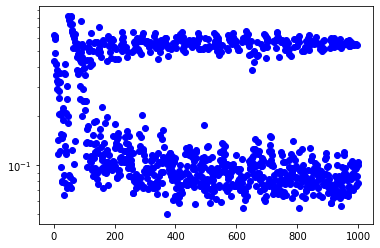

In [12]:
time = [i+1 for i in range(len(dataset))]

plt.plot(time, loss_evolution, 'ob',label='loss')
plt.yscale('log')

## Récupération données 

In [13]:
def recuperation_slha(folder,filename,g,n,sL,sR,h,M,mu,q,c,succes):
    warning = 0
    for j in range(succes):
        file_name =folder+filename+str(j+1)+'.out' 
        
        with open(file_name) as file:
            for indice, ligne in enumerate(file):
                if 'M_1(MX)' in ligne:
                    indices_M = [indice+i for i in range(3)]
                if 'mu(MX)' in ligne:
                    indice_mu = indice
                if 'mqL1(MX)' in ligne:
                    indices_quark_param = [indice+i for i in range(9)]
                if 'h0' in ligne:
                    indices_higgs = [indice+i for i in range(2)]
                if '~g' in ligne:
                    indice_g = indice
                if '~neutralino(1)' in ligne:
                    indices_neutralino = [indice,indice+1,indice+3,indice+4]
                if '~d_L' in ligne:
                    indices_squarkL = [indice+i for i in range(6)]
                if '~d_R' in ligne:
                    indices_squarkR = [indice+i for i in range(6)]
                if '~chargino(1)' in ligne:
                    indices_chargino = [indice,indice+3]
        
        file = open(file_name)
        lignes = file.readlines()
        
        g.append(float(lignes[indice_g].split()[1]))

        for step, i in enumerate(n):
            i.append(float(lignes[indices_neutralino[step]].split()[1]))

        for step, i in enumerate(sL):
            i.append(float(lignes[indices_squarkL[step]].split()[1]))

        for step, i in enumerate(sR):
            i.append(float(lignes[indices_squarkR[step]].split()[1]))

        for step, i in enumerate(h):
            i.append(float(lignes[indices_higgs[step]].split()[1]))

        for step, i in enumerate(M):
            i.append(float(lignes[indices_M[step]].split()[1]))

        mu.append(float(lignes[indice_mu].split()[1]))

        for step, i in enumerate(q):
            i.append(float(lignes[indices_quark_param[step]].split()[1]))
            
        for step, i in enumerate(c):
            i.append(float(lignes[indices_chargino[step]].split()[1]))
    
        with open(file_name) as file:
            if 'LSP # Warning' in file.read():
                warning+=1
    return warning

In [14]:
g_mass = []
neutralino_mass = [[] for i in range(4)]   #[N1 , N2 , N3 , N4]
squarkL_mass = [[] for i in range(6)]      #[d , u , s , c , b , t]
squarkR_mass = [[] for i in range(6)]       
higgs_mass = [[] for i in range(2)]        #[h0 , H0]
chargino_mass = [[] for i in range(2)]   #[neutralino1 , neutralino2]
M_param = [[] for i in range(3)]           #[M1 , M2 , M3]
mu = []                                    
quark_param = [[] for i in range(6)]       #[u , c , t , d , s , b]

folder = 'Jupyter Notebook/softsusy_succes/'
file_name = 'pmssm_nn_succes_'
warning = recuperation_slha(folder,file_name,g_mass,neutralino_mass,squarkL_mass,squarkR_mass,higgs_mass,M_param,mu,quark_param,chargino_mass,ratio[1])

print('Nombre warning:',warning)

Nombre warning: 559


## Plot mass 

In [15]:
def plot_histo(title, xlabel, ylabel, list_hist,bins, label, legend = False, histtype='bar'):
    for indice, hist in enumerate(list_hist):
        plt.hist(hist,bins,label=label[indice],histtype=histtype)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend == True:
        plt.legend()
    
def subplot_histo(titre, xlabel, ylabel, x, y, share, subtitle, hist_list, label, legend = False, histtype='bar'):  
    fig , ax = plt.subplots(x, y, sharex=share[0], sharey=share[1], constrained_layout = True)
    plt.suptitle(titre)
    fig.text(0.5, -0.05, xlabel, ha='center')
    fig.text(-0.04, 0.5, ylabel, va='center', rotation='vertical')

    for indice, hist in enumerate(hist_list): 
        compteur = 0
        for i in range(x):
            if y != 1:
                for j in range(y):
                    ax[i, j].hist(hist[compteur],100,histtype=histtype,label=label[indice])
                    ax[i, j].set_title(subtitle[compteur])
                    compteur+=1
                    if legend == True:
                        ax[i, j].legend()
            else:
                ax[i].hist(hist[compteur],100,histtype=histtype, label=label[indice])
                ax[i].set_title(subtitle[compteur])
                compteur+=1
                if legend == True:
                    ax[i].legend()

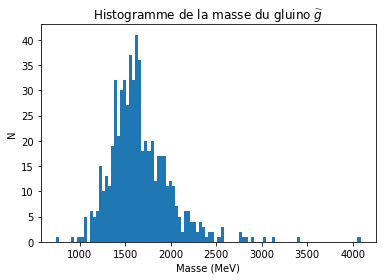

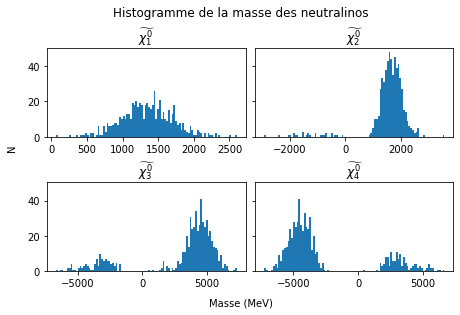

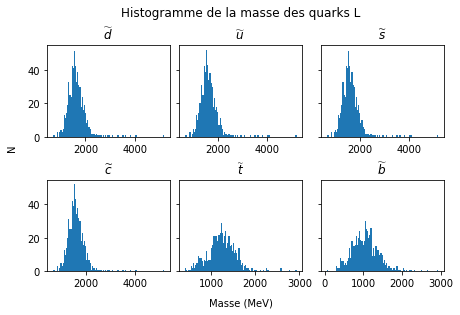

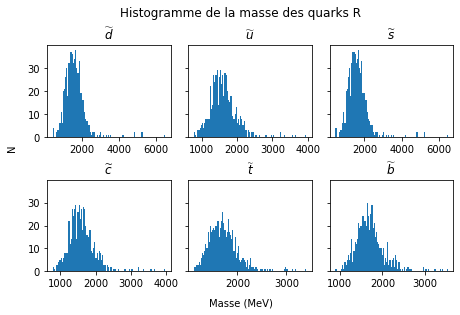

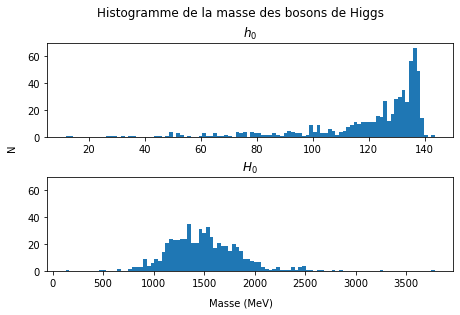

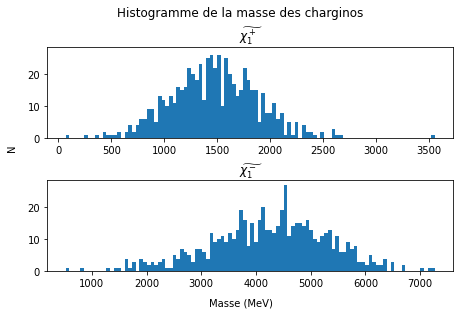

In [16]:
titre = r'Histogramme de la masse du gluino $\widetilde{g}$'
xlabel = 'Masse (MeV)'
ylabel = 'N'
plot_histo(titre,xlabel,ylabel,[g_mass],100,['NN'])

titre = 'Histogramme de la masse des neutralinos'
subtitle = [r'$\widetilde{\chi_1^0}$',r'$\widetilde{\chi_2^0}$',r'$\widetilde{\chi_3^0}$',r'$\widetilde{\chi_4^0}$']
share = [False,True]
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[neutralino_mass],['NN'])

titre = 'Histogramme de la masse des quarks L'
subtitle = [r'$\widetilde{d}$',r'$\widetilde{u}$',r'$\widetilde{s}$',r'$\widetilde{c}$',r'$\widetilde{t}$',r'$\widetilde{b}$']    
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[squarkL_mass],['NN'])

titre = 'Histogramme de la masse des quarks R' 
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[squarkR_mass],['NN'])

titre = 'Histogramme de la masse des bosons de Higgs'    
subtitle = [r'$h_0$',r'$H_0$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[higgs_mass],['NN'])

titre = 'Histogramme de la masse des charginos'    
subtitle = [r'$\widetilde{\chi_1^+}$',r'$\widetilde{\chi_1^-}$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[chargino_mass],['NN'])

## Plots param 

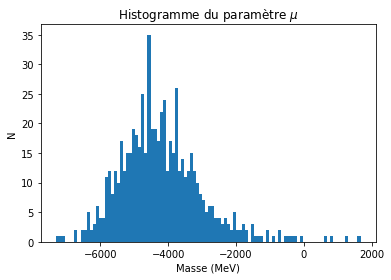

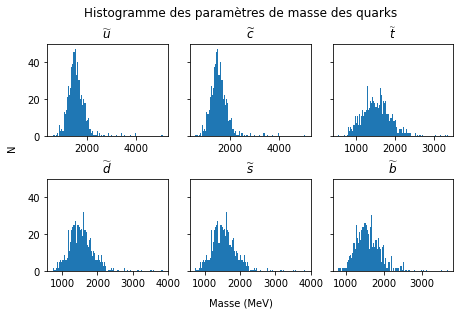

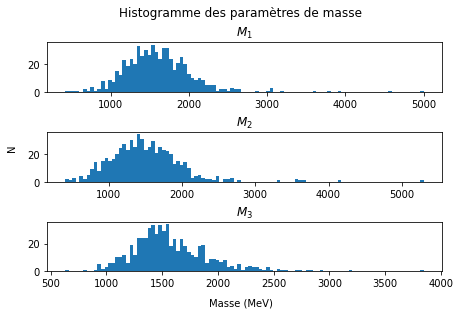

In [17]:
titre = r'Histogramme du paramètre $\mu$'
plot_histo(titre,xlabel,ylabel,[mu],100,['NN'])

titre = 'Histogramme des paramètres de masse des quarks'
subtitle = [r'$\widetilde{u}$',r'$\widetilde{c}$',r'$\widetilde{t}$',r'$\widetilde{d}$',r'$\widetilde{s}$',r'$\widetilde{b}$']
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[quark_param],['NN'])

titre = 'Histogramme des paramètres de masse'
subtitle = [r'$M_1$',r'$M_2$',r'$M_3$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[M_param],['NN'])

# Comparaison Random

In [18]:
def PMSSM_param_random_no_normalization(PMSSM_range):
    PMSSM_sample_random = []
    
    for i in PMSSM_range:
        PMSSM_sample_random.append(rd.uniform(i[0],i[1]))
    
    return PMSSM_sample_random

## Random dataset

In [19]:
random_dataset = []

for i in range(taille_dataset):
    random_dataset.append(PMSSM_param_random_no_normalization(PMSSM_range))

succes_rd=0
os.system('rm Jupyter\ Notebook/softsusy_random/*')
for step, i in enumerate(tqdm(random_dataset)):
    write_slha(i, "Jupyter Notebook/pmssm_nn_random.in")
    output_name = 'pmssm_nn_random_'+str(step+1)+'.out'
    os.system('./SUSY/softsusy-4.1.9/softpoint.x leshouches < Jupyter\ Notebook/pmssm_nn_random.in > Jupyter\ Notebook/'+output_name)
    with open('Jupyter Notebook/'+output_name) as slha_out:
        if 'SOFTSUSY problem' in slha_out.read():
            continue
        else: 
            succes_rd+=1
            output_name_succes = 'pmssm_nn_random_'+str(succes_rd)+'.out'
            commande = 'mv Jupyter\ Notebook/'+output_name+' Jupyter\ Notebook/softsusy_random/'+output_name_succes
            os.system(commande)

os.system('rm Jupyter\ Notebook/*.out')

rm: impossible de supprimer 'Jupyter Notebook/softsusy_random/*': Aucun fichier ou dossier de ce type
100%|███████████████████████████████████████████████████████████████| 1000/1000 [01:34<00:00, 10.56it/s]


0

In [20]:
print("Nombre d'échecs:",taille_dataset-succes_rd)
print("Nombre de succes:",succes_rd)

Nombre d'échecs: 659
Nombre de succes: 341


## Récupération données

In [22]:
g_mass_rd = []
neutralino_mass_rd = [[] for i in range(4)]   #[N1 , N2 , N3 , N4]
squarkL_mass_rd = [[] for i in range(6)]      #[d , u , s , c , b , t]
squarkR_mass_rd = [[] for i in range(6)]       
higgs_mass_rd = [[] for i in range(2)]        #[h0 , H0]
chargino_mass_rd = [[] for i in range(2)]   #[neutralino1 , neutralino2]
M_param_rd = [[] for i in range(3)]           #[M1 , M2 , M3]
mu_rd = []                                    
quark_param_rd = [[] for i in range(6)]       #[u , c , t , d , s , b]

folder = 'Jupyter Notebook/softsusy_random/'
file_name = 'pmssm_nn_random_'
warning_rd = recuperation_slha(folder,file_name,g_mass_rd,neutralino_mass_rd,squarkL_mass_rd,squarkR_mass_rd,higgs_mass_rd,M_param_rd,mu_rd,quark_param_rd,chargino_mass_rd,succes_rd)

print('Nombre warning:',warning_rd)

Nombre warning: 252


## Plots

### Plots mass

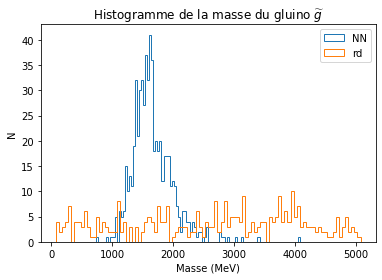

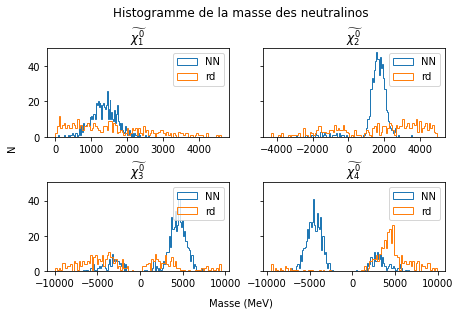

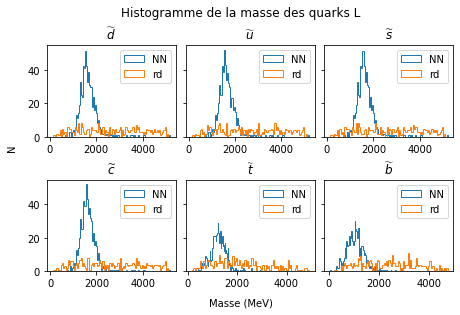

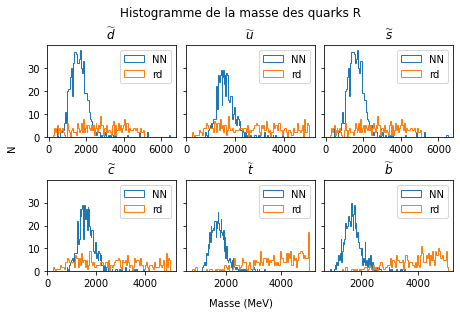

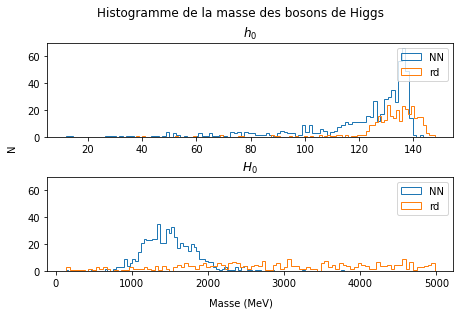

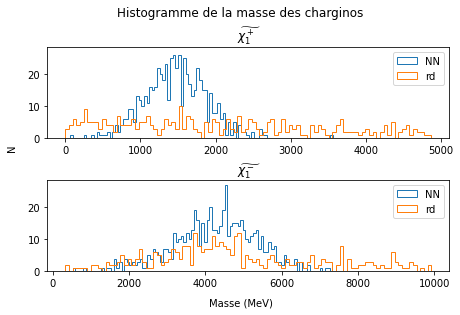

In [23]:
titre = r'Histogramme de la masse du gluino $\widetilde{g}$'
xlabel = 'Masse (MeV)'
ylabel = 'N'
plot_histo(titre,xlabel,ylabel,[g_mass,g_mass_rd],100,['NN','rd'],True,'step')

titre = 'Histogramme de la masse des neutralinos'
subtitle = [r'$\widetilde{\chi_1^0}$',r'$\widetilde{\chi_2^0}$',r'$\widetilde{\chi_3^0}$',r'$\widetilde{\chi_4^0}$']
share = [False,True]
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[neutralino_mass,neutralino_mass_rd],['NN','rd'],True,'step')

titre = 'Histogramme de la masse des quarks L'
subtitle = [r'$\widetilde{d}$',r'$\widetilde{u}$',r'$\widetilde{s}$',r'$\widetilde{c}$',r'$\widetilde{t}$',r'$\widetilde{b}$']    
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[squarkL_mass,squarkL_mass_rd],['NN','rd'],True,'step')

titre = 'Histogramme de la masse des quarks R' 
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[squarkR_mass,squarkR_mass_rd],['NN','rd'],True,'step')

titre = 'Histogramme de la masse des bosons de Higgs'    
subtitle = [r'$h_0$',r'$H_0$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[higgs_mass,higgs_mass_rd],['NN','rd'],True,'step')

titre = 'Histogramme de la masse des charginos'    
subtitle = [r'$\widetilde{\chi_1^+}$',r'$\widetilde{\chi_1^-}$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[chargino_mass,chargino_mass_rd],['NN','rd'],True,'step')

### Plot param 

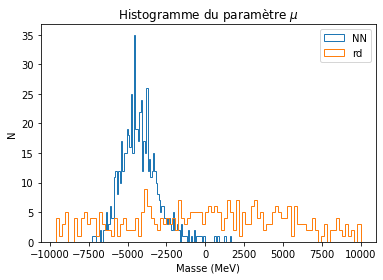

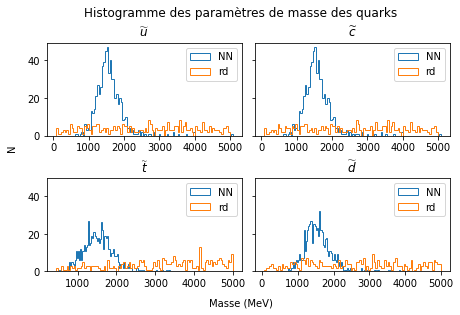

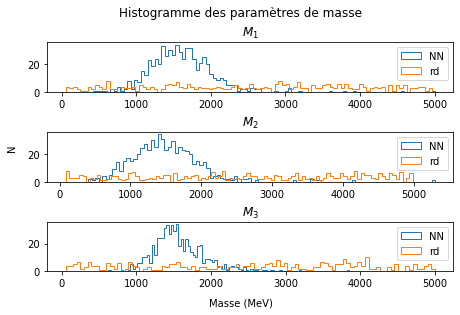

In [24]:
titre = r'Histogramme du paramètre $\mu$'
plot_histo(titre,xlabel,ylabel,[mu,mu_rd],100,['NN','rd'],True,'step')

titre = 'Histogramme des paramètres de masse des quarks'
subtitle = [r'$\widetilde{u}$',r'$\widetilde{c}$',r'$\widetilde{t}$',r'$\widetilde{d}$',r'$\widetilde{s}$',r'$\widetilde{b}$']
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[quark_param,quark_param_rd],['NN','rd'],True,'step')

titre = 'Histogramme des paramètres de masse'
subtitle = [r'$M_1$',r'$M_2$',r'$M_3$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[M_param,M_param_rd],['NN','rd'],True,'step')

# Comparaison NN et random

In [25]:
print('Statisique du Neural Network')
print("Nombre d'échecs:",ratio[0])
print("Nombre de succes:",ratio[1])
print('Nombre warning:', warning)
print('Éfficacité du Neural Network:',ratio[1]/taille_dataset*100,'%')
print('\n')

print('Statisique du random')
print("Nombre d'échecs:",taille_dataset-succes_rd)
print("Nombre de succes:",succes_rd)
print('Nombre warning:', warning_rd)
print('Éfficacité du random:',succes_rd/taille_dataset*100,'%')

Statisique du Neural Network
Nombre d'échecs: 384
Nombre de succes: 616
Nombre warning: 559
Éfficacité du Neural Network: 61.6


Statisique du random
Nombre d'échecs: 659
Nombre de succes: 341
Nombre warning: 252
Éfficacité du random: 34.1


<AxesSubplot:>

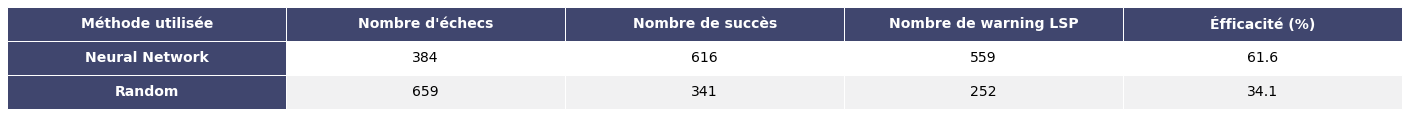

In [35]:
import pandas as pd
import six

df = pd.DataFrame()
df['Méthode utilisée'] = ['Neural Network','Random']
df["Nombre d'échecs"] = [ratio[0],taille_dataset-succes_rd]
df['Nombre de succès'] = [ratio[1],succes_rd]
df['Nombre de warning LSP'] = [warning,warning_rd]
df['Éfficacité (%)'] = [ratio[1]/taille_dataset*100,succes_rd/taille_dataset*100]


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(df, header_columns=1, col_width=5.0, cellLoc='center')